# VGG16 Temporal Action recognition

In [19]:
from prelude import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import transform, filter
import sys, pylab, operator, csv
import util
import os
import urllib
import imageio
import beoid
import itertools
from skimage.io import Image
import caffe
caffe.set_mode_gpu()

import cnn_utils
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
model_root_path = "/home/will/nets/vgg_16_ucf101/"
model_name = "cuhk_action_temporal_vgg_16_split1"

deploy_prototxt_path = os.path.join(model_root_path, model_name + "_deploy.prototxt")
caffemodel_path = os.path.join(model_root_path, model_name + ".caffemodel")


net = caffe.Net(deploy_prototxt_path,
                caffemodel_path,
                caffe.TEST)

# The very last layer in the network (pre loss layer)
topLayerName = 'fc8'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'fc7'
secondTopBlobName = net.top_names[secondTopLayerName][0]

# This is the layer we'll stop at when excitation backpropping
outputLayerName = 'pool3'

In [12]:
data_root = "/home/will/thesis/generated/ucf101/temporal/test-1/flow/"
video_name = "v_HorseRace_g04_c05"

start_frame_index = 1
stop_frame_index = start_frame_index + 10
#image_path = os.path.join(data_root, "desk-plug-plug/frame000084.jpg")¬
#image_path = os.path.join(data_root, "treadmill-press-button/frame000034.jpg")
#image_path = os.path.join(data_root, "printer-press-button/frame000010.jpg")
#image_path = os.path.join(data_root, "push_drawer/frame000057.jpg")
#image_path = os.path.join(data_root, "insert_screwdriver/frame000135.jpg")
u_frames = [os.path.join(data_root, "u", video_name, "frame{:06d}.jpg".format(frame_index)) for frame_index in range(start_frame_index, stop_frame_index)]
v_frames = [os.path.join(data_root, "v", video_name, "frame{:06d}.jpg".format(frame_index)) for frame_index in range(start_frame_index, stop_frame_index)]

image_paths = list(itertools.chain(*zip(u_frames, v_frames)))

new_size = (224, 224)

images = [transform.resize(caffe.io.load_image(image_path)[:, :, 0], new_size) for image_path in image_paths]
images = np.array(images)
optical_flow_gif = video_name + ".gif"
imageio.mimsave(optical_flow_gif, images)
from IPython.display import HTML
HTML("<img src=\"{}\" />".format(optical_flow_gif))

/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [37]:
pathological_examples_root = "/home/will/thesis/pathological-inputs/"
black = caffe.io.load_image(os.path.join(pathological_examples_root, "black.png"), color=False)
left_bottom = caffe.io.load_image(os.path.join(pathological_examples_root, "bottom-left.png"), color=False)
left_mid = caffe.io.load_image(os.path.join(pathological_examples_root, "mid-left.png"), color=False)
left_top = caffe.io.load_image(os.path.join(pathological_examples_root, "top-left.png"), color=False)

u_frames = [left_mid] + [black]*9
v_frames = [black]*10
images = np.array(list(itertools.chain(*zip(u_frames, v_frames))))
images.shape
#Image(images[0, :, :])

(20, 224, 224, 1)

In [38]:
cnn_utils.print_layer_shapes(net)

Layer shapes (output)

data      : [(1, 20, 224, 224)]
label_local: [(1, 1, 1, 1)]
label     : [(1, 1, 1, 1)]
label_label_0_split: [(1, 1, 1, 1), (1, 1, 1, 1)]
conv1_1   : [(1, 64, 224, 224)]
relu1_1   : [(1, 64, 224, 224)]
conv1_2   : [(1, 64, 224, 224)]
relu1_2   : [(1, 64, 224, 224)]
pool1     : [(1, 64, 112, 112)]
conv2_1   : [(1, 128, 112, 112)]
relu2_1   : [(1, 128, 112, 112)]
conv2_2   : [(1, 128, 112, 112)]
relu2_2   : [(1, 128, 112, 112)]
pool2     : [(1, 128, 56, 56)]
conv3_1   : [(1, 256, 56, 56)]
relu3_1   : [(1, 256, 56, 56)]
conv3_2   : [(1, 256, 56, 56)]
relu3_2   : [(1, 256, 56, 56)]
conv3_3   : [(1, 256, 56, 56)]
relu3_3   : [(1, 256, 56, 56)]
pool3     : [(1, 256, 28, 28)]
conv4_1   : [(1, 512, 28, 28)]
relu4_1   : [(1, 512, 28, 28)]
conv4_2   : [(1, 512, 28, 28)]
relu4_2   : [(1, 512, 28, 28)]
conv4_3   : [(1, 512, 28, 28)]
relu4_3   : [(1, 512, 28, 28)]
pool4     : [(1, 512, 14, 14)]
conv5_1   : [(1, 512, 14, 14)]
relu5_1   : [(1, 512, 14, 14)]
conv5_2   : [(1, 512,

In [10]:
#images -= images.mean()

In [39]:
eb = cnn_utils.ExcitationBackprop(net, 'fc8', 'fc7', 'pool3')
net.blobs['data'].data[...] = images.reshape(1, 20, *new_size)
out = net.forward(end = topLayerName)

class_count = 101
scores = net.blobs[eb.top_blob_name].data[0].reshape(class_count, -1).max(1).flatten() # pre-softmax scores
class_ids = scores.argsort()[-3:][::-1]

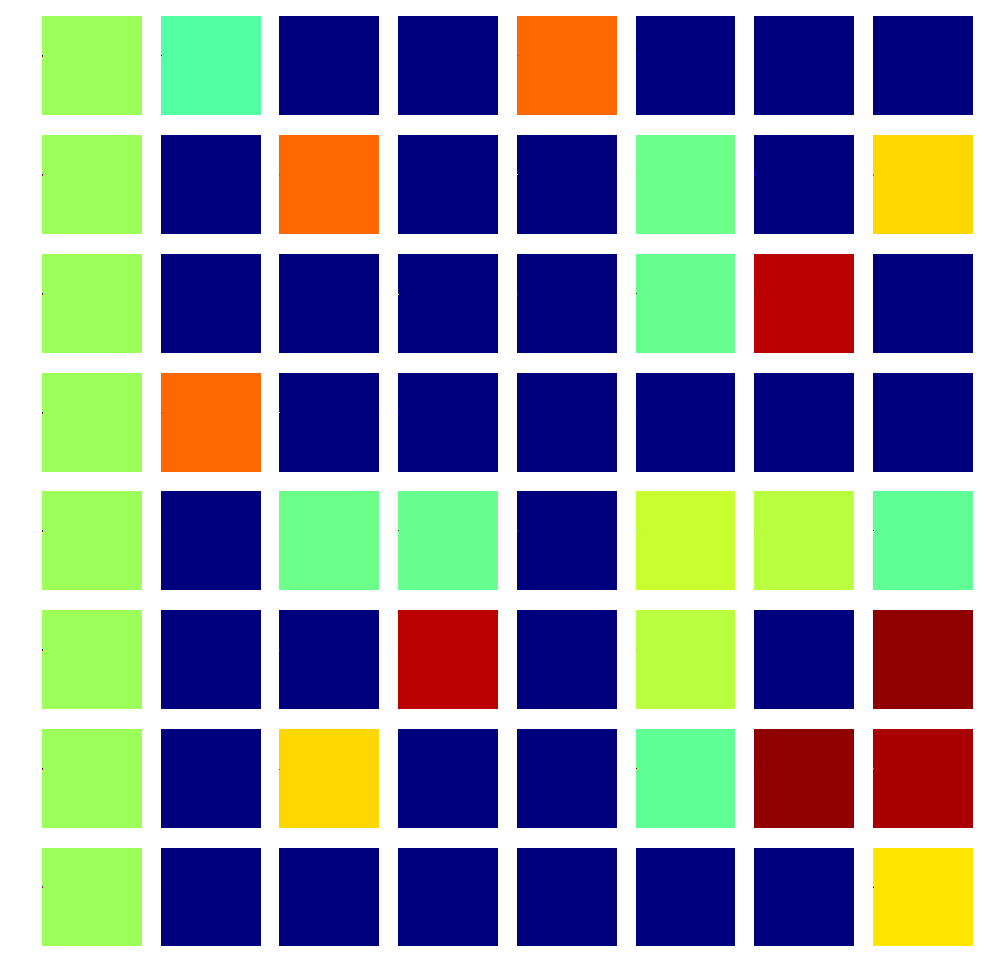

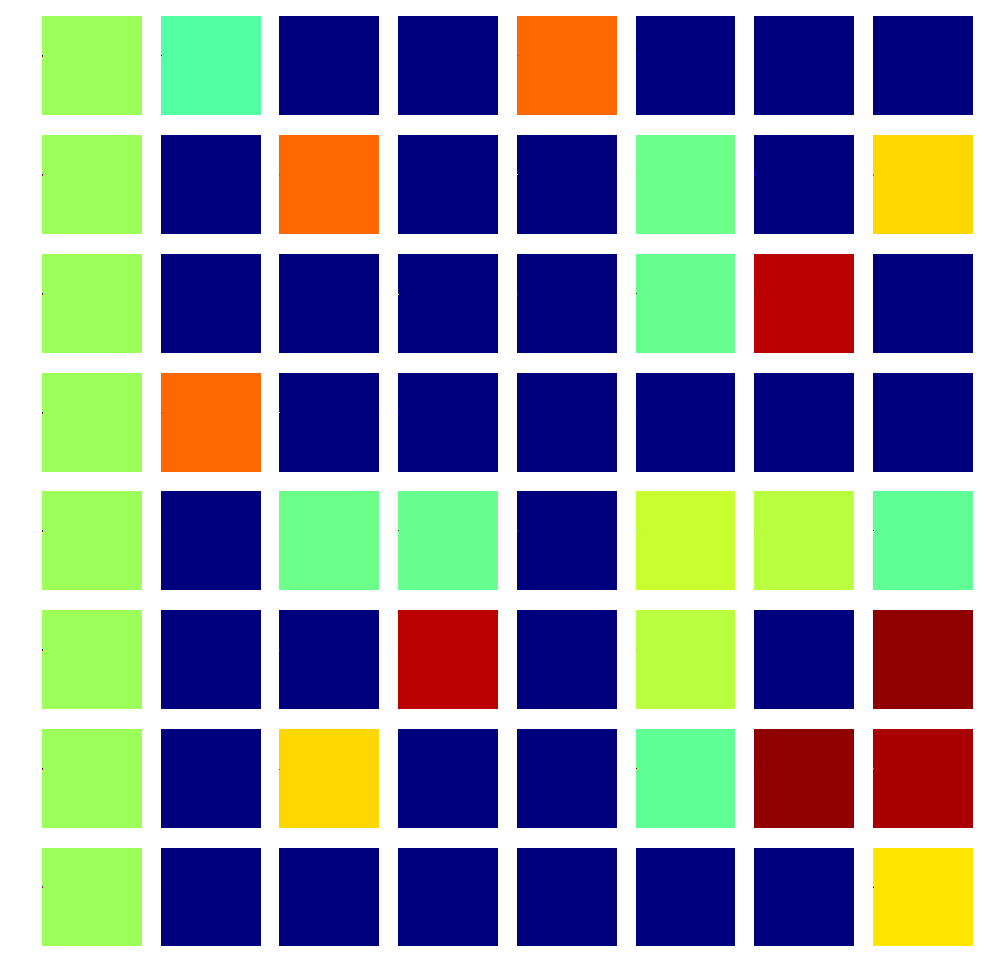

In [48]:
cnn_utils.show_filters_responses(net.blobs['conv1_2'])

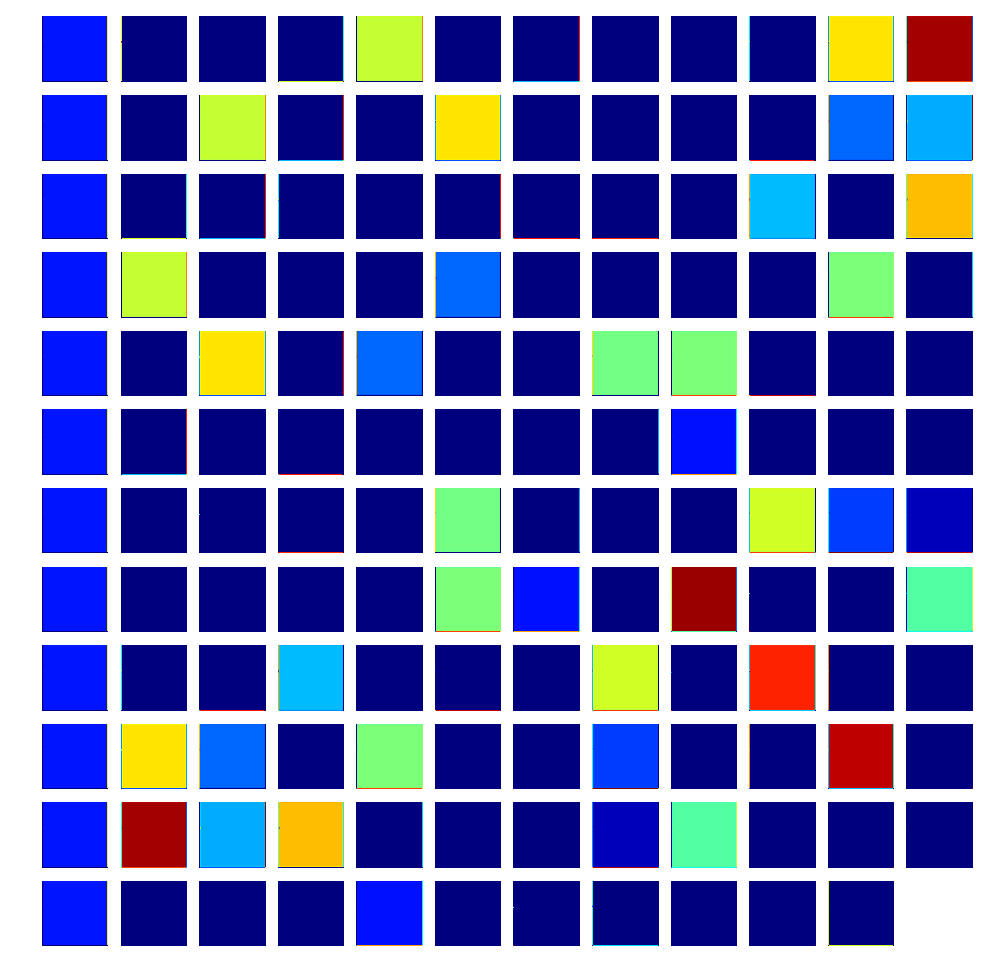

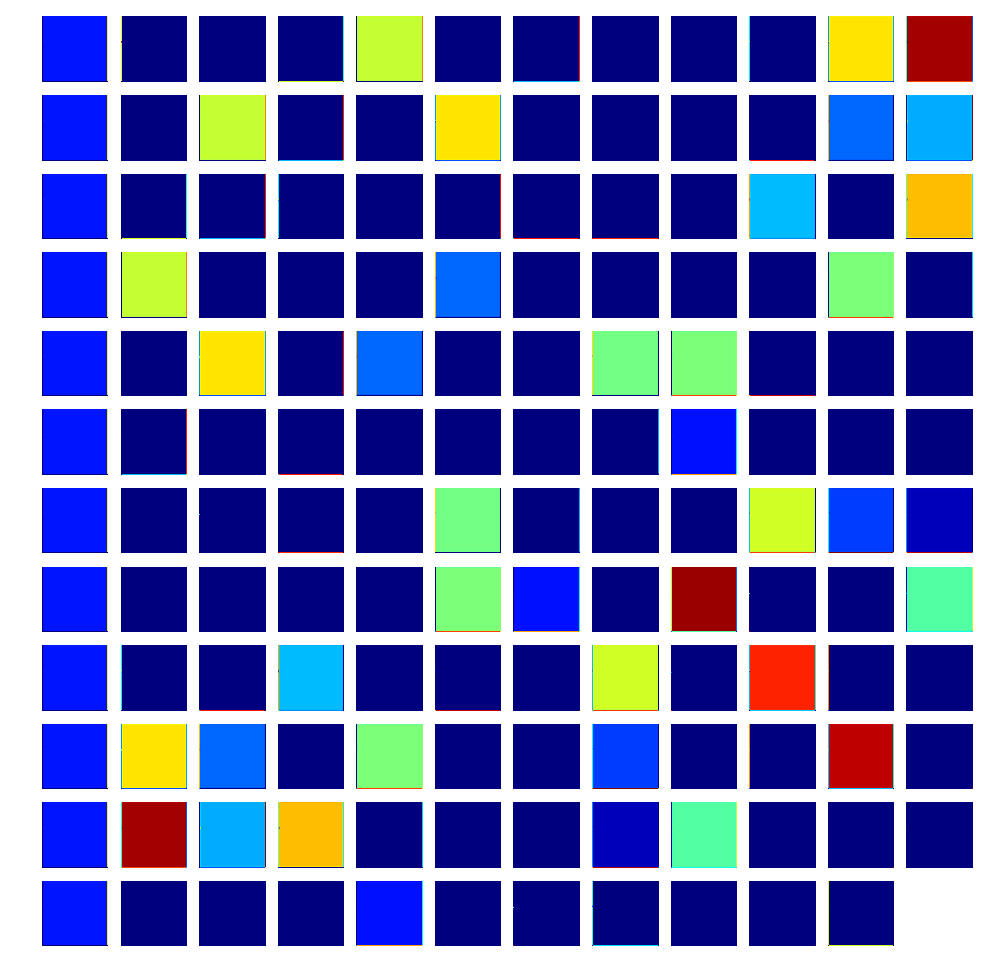

In [47]:
cnn_utils.show_filters_responses(net.blobs['conv2_2'])

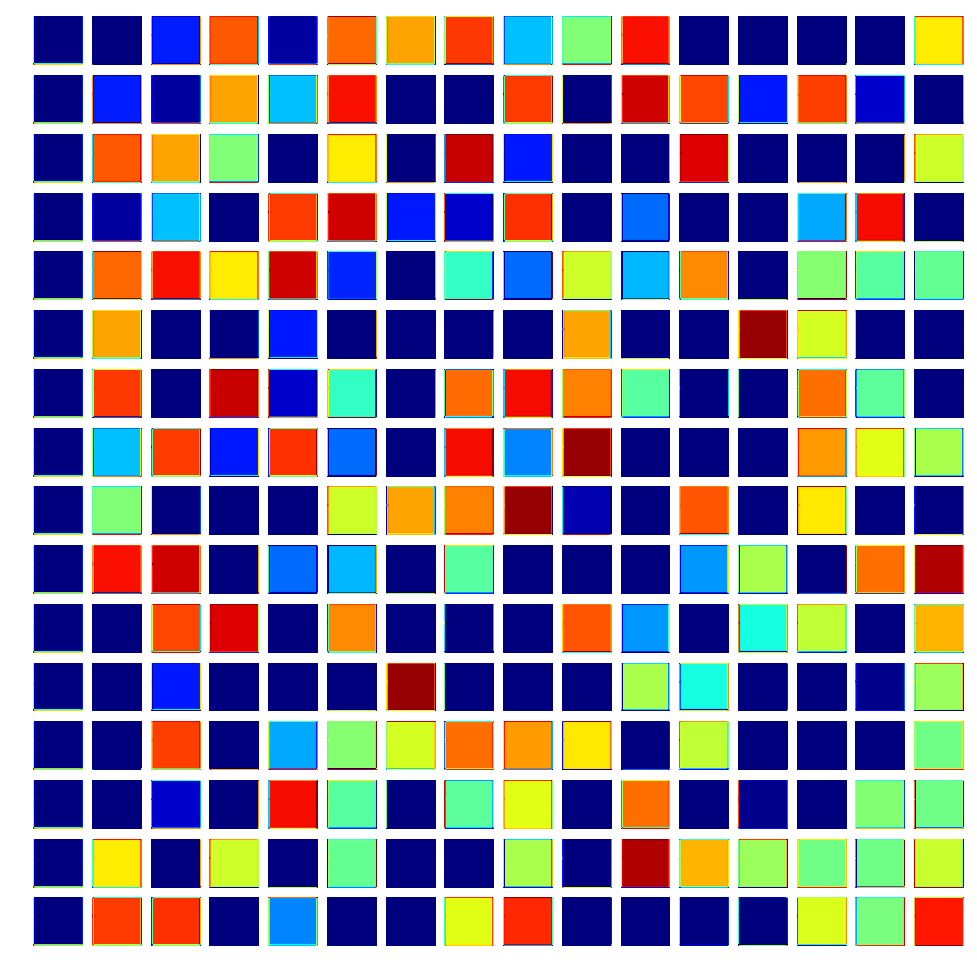

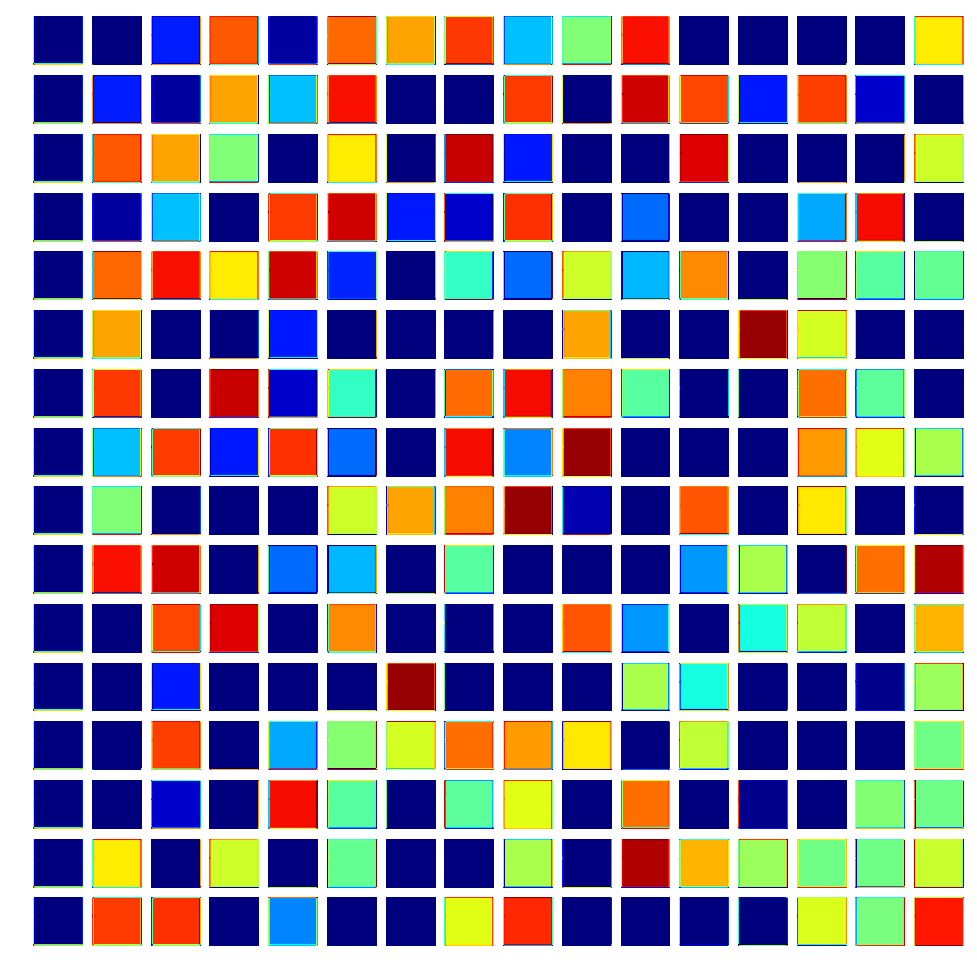

In [46]:
cnn_utils.show_filters_responses(net.blobs['conv3_1'])

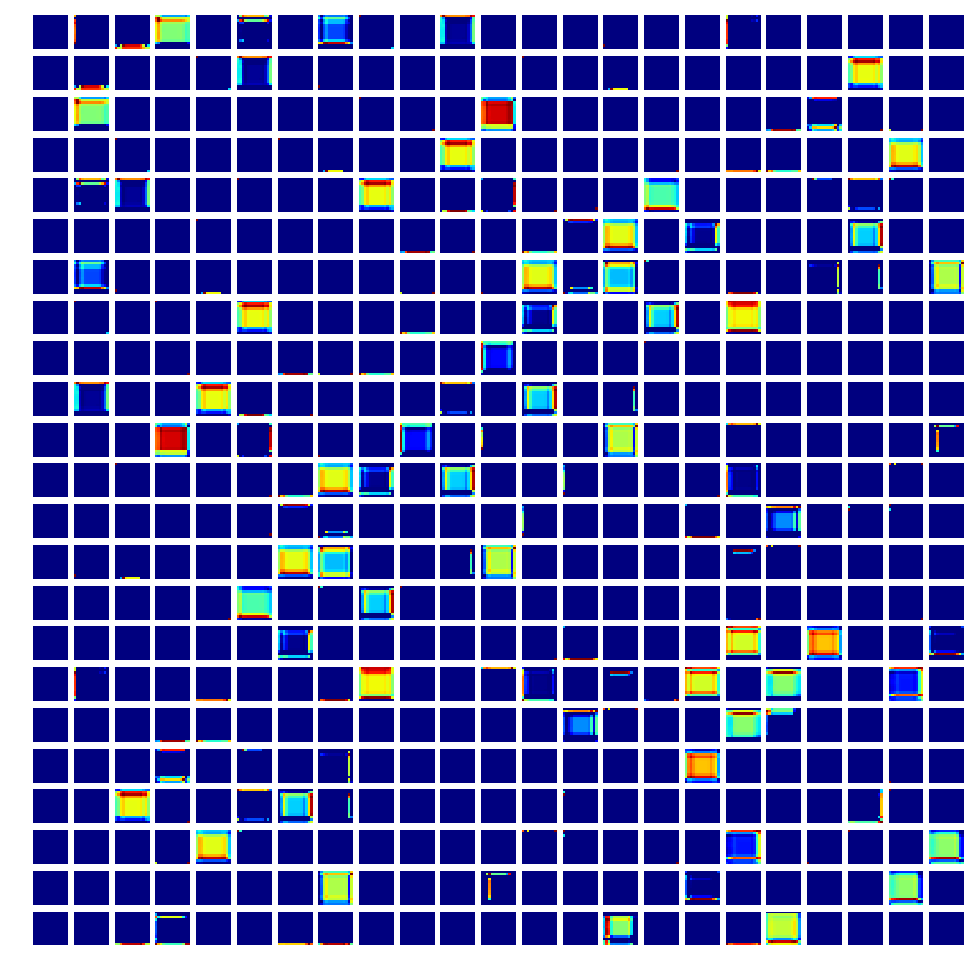

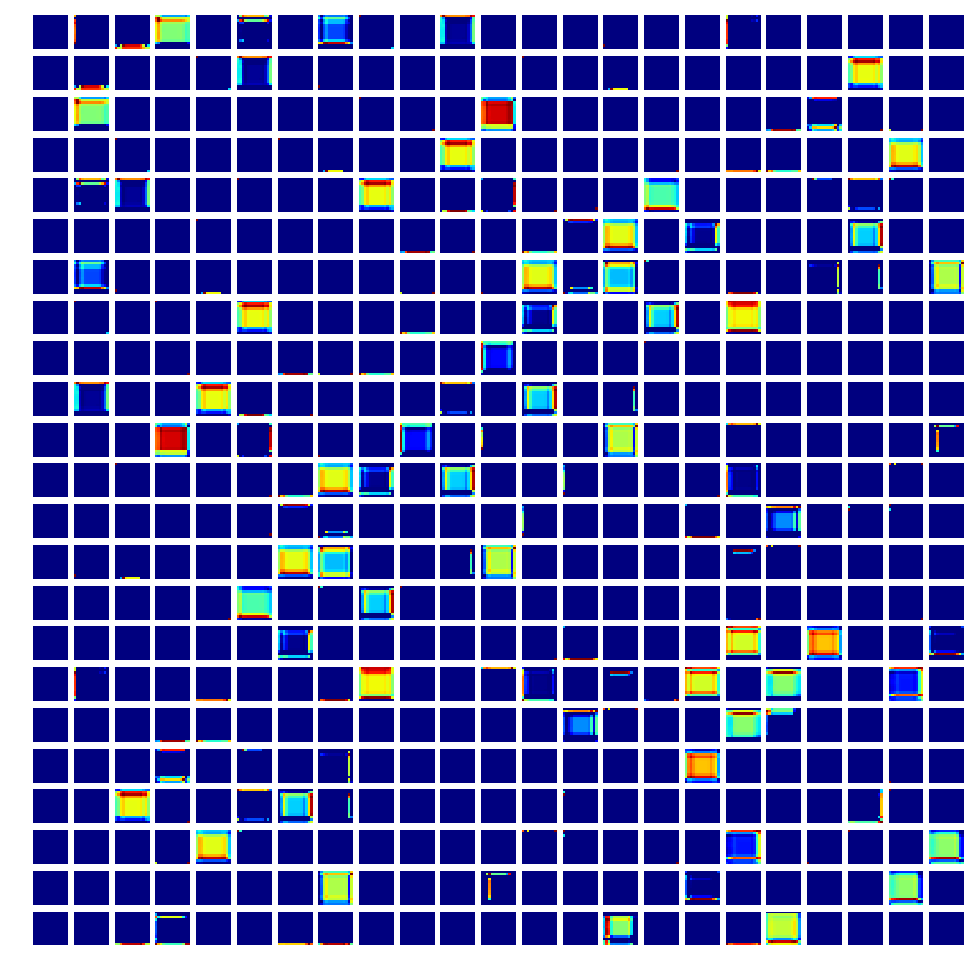

In [45]:
cnn_utils.show_filters_responses(net.blobs['conv5_2'])